# Quick Start

GammaBayes is a python package that handles two-level Bayesian hierarchical inference model that allows one to infer on parameters related to gamma-ray flux from gamma ray event data specifically for the Cherenkov Telescope Array Observatory (but by replacing the relevant instrument response functions could do it for any energy, longitude, latitude data).

Because CTAO is not fully online GammaBayes also currently has the capability to simulate given event data based on specified sources and relevant parameters. So a typical use case is to:

- Define all required observation meta-data
- Generate reconstructed event data
- Define parameters to be inferred on and how these will be analysed
- Marginalise over nuisance parameter values of the given events
- Use these marginalised probabilities to stochastically sample the space of parameters previously defined

In this tutorial we will very quickly go over the bare-bones things that need to be defined with little detail of the underlying principles of how these values are used internal to the code, but of course explain the main outputs.

If one wants to do a similar process from a text configuration file we would also direct the user to the High Level Inference tutorial.

## Observation Meta-Data

By 'meta data' here we refer to the region of energy and angular values, the sources, the number of events, how much each source contributes to the overall number of events, and other observation meta-data. 

First we define the 'binning geometry' for the observations which contain the range of energy and angular values to be used.

We choose to explore the energy values between 0.1 TeV and 100 TeV with 50 bins per decade, -3.05 to +3.05 degress in Galactic Longitude and Latitude with a resolution of 0.4 deg (large but will decrease memory consumption for this tutorial).

We use these values for the reconstructed values and 'true' values of the events. The reconstructed values being what would be measured by CTAO and the 'true' values being what the telescope would see if it had infinite precision/the actual values of the events.

In [1]:
from astropy import units as u
from gammabayes import GammaBinning
import numpy as np


min_energy = 0.1*u.TeV
max_energy = 100*u.TeV
energy_bins_per_decade  = 50

min_lonlat = -3.2*u.deg
max_lonlat = 3.2*u.deg
angular_resolution = 0.4*u.deg


# Numpy arange has a bit numerical instability regarding the max value
angular_axis = np.arange(min_lonlat.value, max_lonlat.value+1e-5, angular_resolution.value)*u.deg

true_binning_geometry = GammaBinning(energy_axis=np.logspace(
                                                np.log10(min_energy.value),
                                                np.log10(max_energy.value),
                                                energy_bins_per_decade
                                                )*u.TeV,
                                    lon_axis=angular_axis,
                                    lat_axis=angular_axis,
                                    )


recon_binning_geometry = GammaBinning(energy_axis=np.logspace(
                                                np.log10(min_energy.value),
                                                np.log10(max_energy.value),
                                                energy_bins_per_decade
                                                )*u.TeV,
                                    lon_axis=angular_axis,
                                    lat_axis=angular_axis,
                                    )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this tutorial we will presume a single observation with pointing direction of the array at the Galactic Centre for 50 hours (impossible for IACTs but let's keep it simple).

In [2]:
pointing_direction  = np.array([0.,0.])*u.deg
observation_time = 50*u.hr

From this we can define the Instrument Response Functions and exposure, which in GammaBayes is stored in a class for the log of these values.

In [3]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes import GammaLogExposure

In [4]:
irf_loglikelihood = IRF_LogLikelihood(
    pointing_dir=pointing_direction,
    observation_time=observation_time,
    axes=recon_binning_geometry.axes,
    dependent_axes=true_binning_geometry.axes,
)

log_exposure = GammaLogExposure(
    binning_geometry=true_binning_geometry,
    irfs=irf_loglikelihood,
    pointing_dir=pointing_direction,
    observation_time=observation_time
)

We then need to define some sources, which as GammaBayes is a probabilistic inference package sources are contained with the `DiscreteLogPrior` class which contains unnormalised prior probablity distributions (with the ability to normalise when required).

To save time we will also use sources already defined within this package and the residual cosmic ray background, a model of which comes along with the Instrument Response Functions.

In [5]:
from gammabayes.priors import HESSCatalogueSources_Prior, FermiGaggeroDiffusePrior, ObsFluxDiscreteLogPrior

localised_sources_prior = HESSCatalogueSources_Prior(
    binning_geometry=true_binning_geometry,
    log_exposure_map=log_exposure
)


diffuse_sources_prior = FermiGaggeroDiffusePrior(
    binning_geometry=true_binning_geometry,
    log_exposure_map=log_exposure
)

ccr_prior = ObsFluxDiscreteLogPrior(
    name='CCR_BKG',
    logfunction=irf_loglikelihood.log_bkg_CCR,
    binning_geometry=true_binning_geometry,
    observation_time=observation_time,
    pointing_dir=pointing_direction
    
)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:583: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


We could use the default normalisations to figure out how much each source contributes, or we can specify by how many events each contributes. We will assign half the events to the residual cosmic ray background, a sixth to the diffuse background and a third to the localised background with a total of 4500 (2250, 750 and 1500 respectively).

In [6]:
total_num_events = 4500
ccr_frac = 1/2
diffuse_frac = 1/6
localised_frac = 1/3

## Simulations

### High Level Simulation

We will first simply use the `GammaBayes` class `SimulationContainer` where we plug in the above information and easily get the event data.

In [7]:
from gammabayes.high_level_inference import SimulationContainer
from gammabayes.hyper_inference import MTree

mixture_tree = MTree()
mixture_tree.create_tree(layout=['FermiGaggeroDiffusePrior',
                                         'HESSCatalogueSources_Prior',
                                         'CCR_BKG'],
                                values=[diffuse_frac, 
                                        localised_frac, 
                                        ccr_frac])


sim_container = SimulationContainer(priors=[
                            localised_sources_prior, 
                            diffuse_sources_prior, 
                            ccr_prior], 
                                    irf_loglikes=irf_loglikelihood, 
                                    mixture_tree=mixture_tree, 
                                    true_binning_geometry=true_binning_geometry,
                                    recon_binning_geometry = recon_binning_geometry,
                                    log_exposures=[log_exposure],
                                    observation_times=[observation_time],
                                    pointing_dirs=[pointing_direction],
                                    Nevents=total_num_events
                                    )


ic| event_counts: {'CCR_BKG': 19346,
                   'FermiGaggeroDiffusePrior': 87,
                   'HESSCatalogueSources_Prior': 191}


Then just call the simulate method and a dictionary containg the data will be returned.

In [8]:
obs_containers = sim_container.simulation_observation_set()

100%|██████████| 1/1 [00:34<00:00, 34.52s/it]


In [9]:
event_data = obs_containers['Observation_0']['measured_event_data']

To take a peak at the event data just call the peek method.

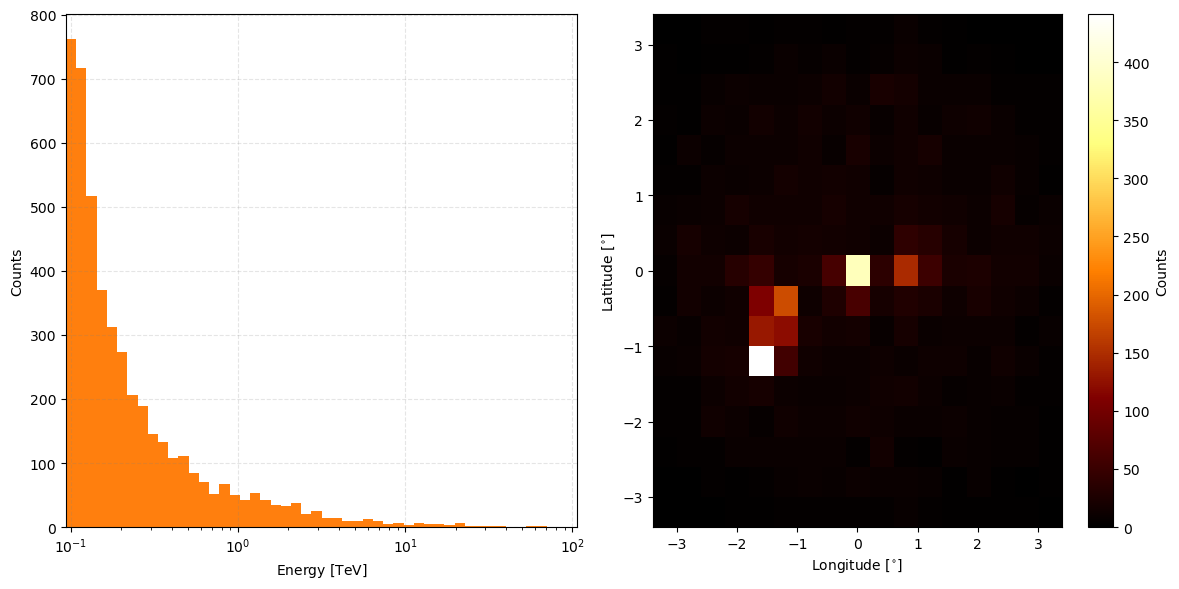

In [10]:
from matplotlib import pyplot as plt

event_data.peek()
plt.show()

And if you would prefer this in log-scale add the keyword parameter `count_scaling='log'`

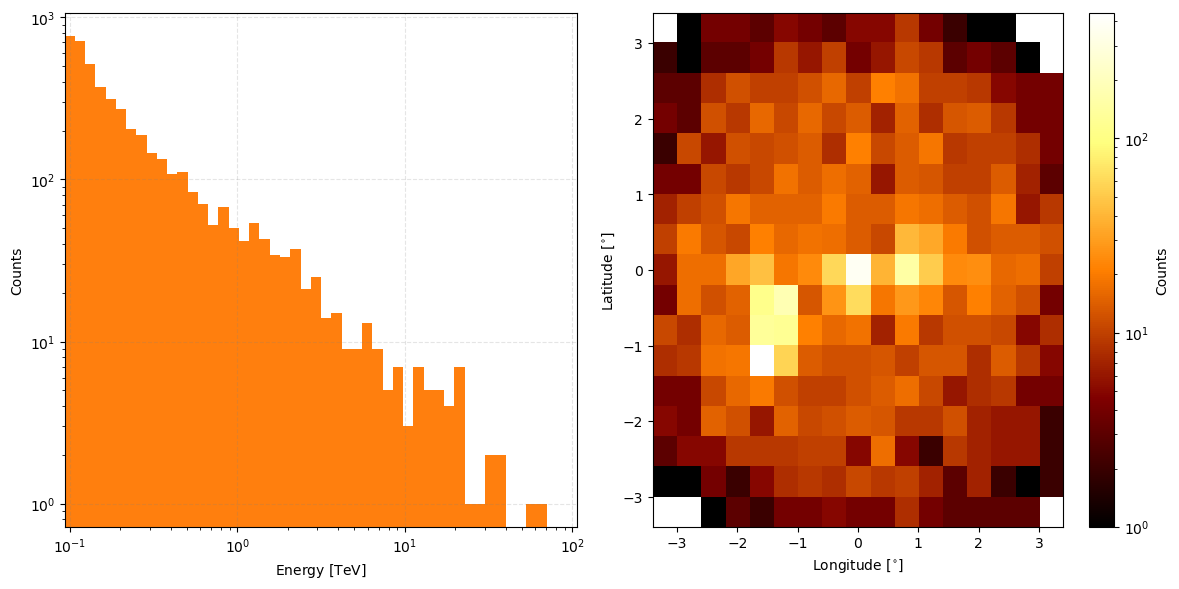

In [11]:
from matplotlib import pyplot as plt

event_data.peek(count_scaling='log')
plt.show()

### Low Level Simulation

If you wanted a slightly more manual touch you can also call the sample methods on the priors and get the individual true event data, then add noise by passing this data through the Instrument Reponse Functions.

First we get the true event data.

In [12]:
diffuse_true_event_data = diffuse_sources_prior.sample(
                                        numsamples=int(round(diffuse_frac*total_num_events)),
                                        )


localised_true_event_data = localised_sources_prior.sample(
                                        numsamples=int(round(localised_frac*total_num_events)),
                                        )

ccr_true_event_data = ccr_prior.sample(
                                        numsamples=int(round(ccr_frac*total_num_events)),
                                        )

Taking a peek at the true event data.

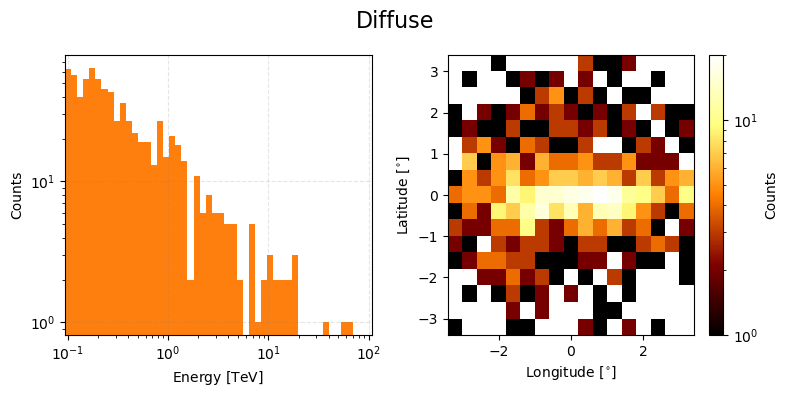

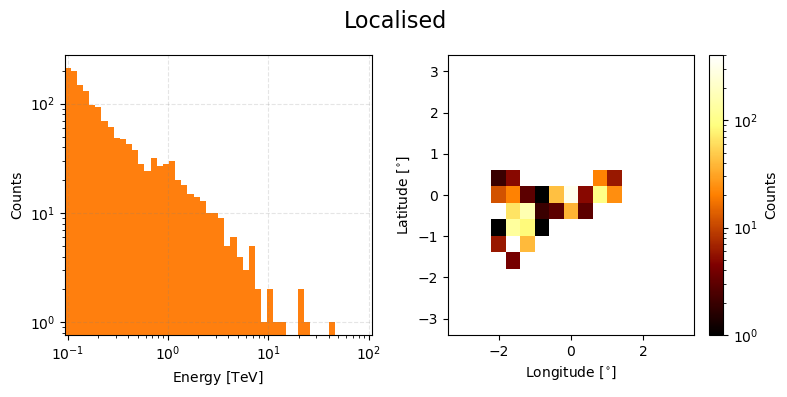

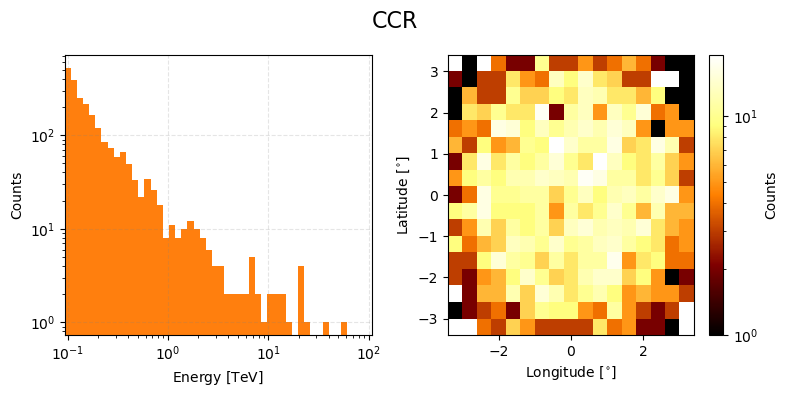

In [13]:

ax = diffuse_true_event_data.peek(figsize=(8,4), count_scaling='log')
plt.suptitle("Diffuse", size=16)
plt.tight_layout()
plt.show()

ax = localised_true_event_data.peek(figsize=(8,4), count_scaling='log')
plt.suptitle("Localised", size=16)
plt.tight_layout()
plt.show()


ax = ccr_true_event_data.peek(figsize=(8,4), count_scaling='log')
plt.suptitle("CCR", size=16)
plt.tight_layout()
plt.show()

We can then combine this data together and pass it through `irf_loglikelihood` to get the reconstructed event values. 

This will take a little while longer than simulating the true event data (<2 mins) because for each unique true event value we need to evaluate the whole range of reconstructed value axes and sample over them.

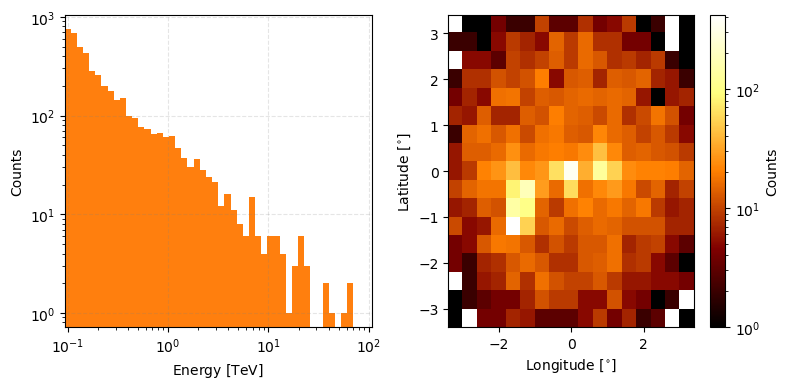

In [14]:
combined_true_event_data = localised_true_event_data+diffuse_true_event_data+ccr_true_event_data

reconstructed_event_data = irf_loglikelihood.sample(eventdata=combined_true_event_data)


reconstructed_event_data.peek(figsize=(8,4), count_scaling='log')
plt.tight_layout()
plt.show()

## Nuisance Parameter Marginalisation

For each event if we wanted the probability that it came from a given model for some set of parameters then this probability would be dependent on the 'true' values of the event. 

We do not care for these individual true values (at least most of the time) and thus treat them as nuisance parameters which we will exclude from the results of our analysis through the method of marginalisation.

Marginalisation essentially integrates out the dependencies of the nuisance parameters from the probabilities giving us just the probability of the events given the given models and the parameters we are performing inference on.

Luckily all the hard stuff has already been done as the key ingredients needed to be defined to perform the simulation. 

One particular thing that we need to do is ensure that when we use our likelihoods that they are normalised. This is doubly ensured by evaluating all the normalisation values they take beforehand, caching them in a matrix, which is then supplied to whatever is doing the nuisance marginalisation.

In [15]:
from gammabayes.hyper_inference import DiscreteAdaptiveScan
edisp_log_norm_matrix, psf_log_norm_matrix = irf_loglikelihood.create_log_norm_matrices()


irf_log_norm_matrix = edisp_log_norm_matrix+psf_log_norm_matrix

Setting up edisp normalisation: 100%|██████████| 50/50 [00:00<00:00, 318.36it/s]


We then pass all the required information for everything to the `DiscreteAdaptiveScan` class. Although we note that the only parameters being explored here are the mixture parameters so our `prior_parameter_specifications` is an empty dictionary.

For this step we don't need to define the mixture parameters but will later.

In [16]:
nuisance_marginaliser = DiscreteAdaptiveScan(
    log_priors=[diffuse_sources_prior, localised_sources_prior, ccr_prior], 
    log_likelihood=irf_loglikelihood, 
    axes = recon_binning_geometry.axes,
    nuisance_axes = true_binning_geometry.axes,
    prior_parameter_specifications = {}, 
    log_likelihoodnormalisation = irf_log_norm_matrix, 
    bounds = [['log10', 1.0], ['linear', 1.3], ['linear', 1.3]],
)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/core/utils.py:57: UserWarning: 
You have specifed 3 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""


Then we just call the `nuisance_log_marginalisation` method to get the log of the nuisance marginalised probability values.

In [17]:
log_marg_results = nuisance_marginaliser.nuisance_log_marginalisation(
    reconstructed_event_data,
    )

So to be 100% clear here, each entry of `log_marg_results` contained the log-probaiblities of the reconstructed event values coming from the three sources (priors) we defined above with a likelihood defined as the product between the energy dispersion and point spread functions contained within `irf_loglikelihood`.

## Hyperparameter Inference

We now define the priors we will use when exploring the values of the mixture parameters for each source/observational prior. We will choose uninformative symmetric Dirichlet distributions all with alpha values equalling one.

These parameters will not be treated as discrete and must have values between 0 and 1. 

We also need to say what other parameters are dependent on each other, but once we've done this for which is defined first we don't need to do it for the others.

In [19]:
mixture_parameter_specifications = {
    'FermiGaggeroDiffusePrior':{
        'discrete': False,
        'bounds': [0., 1.],
        'dependent': ['HESSCatalogueSources_Prior', 'CCR_BKG'],
        'custom_dist_name': 'dirichlet',
        'custom_dist_kwargs': 
            {'alpha': [
                1., 
                1.,
                1.]}},

    'HESSCatalogueSources_Prior':
        {'discrete': False,
        'bounds': [0., 1.]},

    'CCR_BKG':
        {'discrete': False,
        'bounds': [0., 1.]}
        }


Now if you looked at the length/shape of the items in `log_marg_results` you may notice that they don't match the number of events weve specified. That is because the specific container that was passed through when indexed only gives the unique event values. So for each of the calculated values we also need the number of times they occured, this is held in the same object and can be accessed as below (the zero index being the unique coordinate data).

In [30]:
meas_event_weights =  reconstructed_event_data.nonzero_bin_data[1]

We can then pass this information to `ScanOutput_StochasticTreeMixturePosterior` which as in the name, takes the log marginalisation results from a result of a parameter scan so that it can stochastically explore the space in addition to continuous mixture values (stored in a tree structure).

In [20]:
from gammabayes.hyper_inference import ScanOutput_StochasticTreeMixturePosterior


hyper_instance = ScanOutput_StochasticTreeMixturePosterior(
    mixture_tree = mixture_tree,
    log_nuisance_marg_results= log_marg_results,
    mixture_parameter_specifications= mixture_parameter_specifications,
    prior_parameter_specifications = {},
    shared_parameters = {},
    event_weights = meas_event_weights,
)

One can then use the in-built sampler which defaults to the `dynesty` package (if you would prefer to use a different nested sampler you can also extract the likelihood and prior transform from this class as well as is done in other tutorials). If you do this, then it is at this stage that you would pass the parameters you would to the nested sampler when instantiating it.

In [26]:
hyper_instance.initiate_exploration(nlive=500,)

We then run the stored sampler again passing in any arguments that you would when calling the `run` method of the `dynesty` nested sampler.

In [27]:
hyper_instance.run_exploration(dlogz=0.5)

7859it [21:01,  6.23it/s, +1000 | bound: 1823 | nc: 1 | ncall: 2770709 | eff(%):  0.320 | loglstar:   -inf < -20332.038 <    inf | logz: -20338.574 +/-  0.074 | dlogz:  0.000 >  0.300]


When can then access the results from the results attribute of the class.

In [28]:
results = hyper_instance.results

Then with a bit of `corner.corner` and some kwargs from `GammaBayes` for some styling.

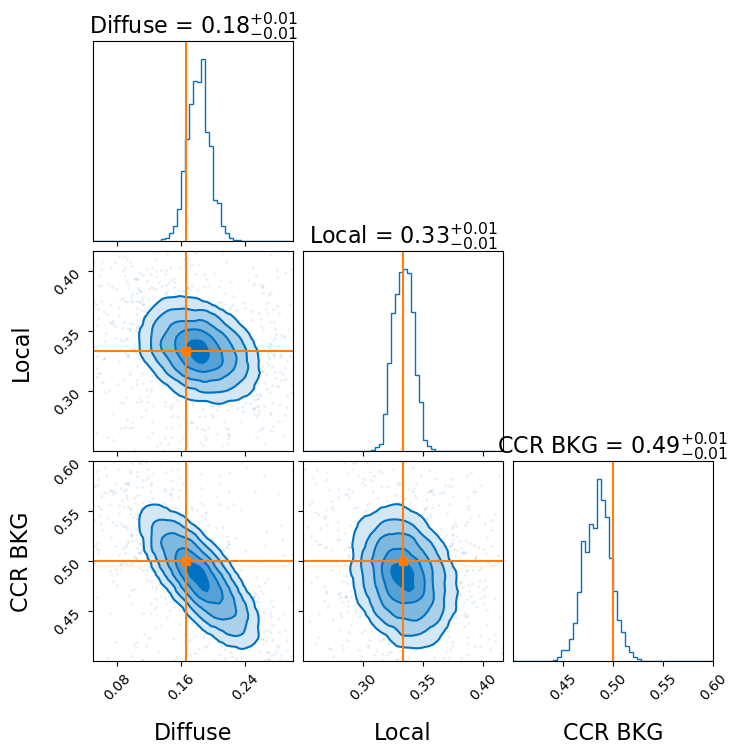

In [76]:
from corner import corner
from gammabayes.utils.plotting import defaults_kwargs


corner(results.samples, 
       weights= np.exp(results.logwt-results.logwt.mean()),
       bins=50,
       range=[[0.05,0.3], [1/4, 5/12], [0.4, 0.6]],
       truths=[diffuse_frac, localised_frac, ccr_frac],
       **defaults_kwargs,
       labels=['Diffuse', 'Local', 'CCR BKG'],
       show_titles=True)
plt.show()

So we've been able to quite precisely recover the contribution of each source for event data with purposefully added noise that follows information of the instrument through the Instrument Response Functions with only 4500 events.